## Short-term volatility Prediction using Markov Model Classification & LSTM ML

### Import Packages

In [1]:
from yahoofinancials import YahooFinancials
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

### Model Parameters & Document Settings

In [32]:
# timeframe
start_date="2008-01-01"
end_date="2021-12-31"
time_interval="daily"

# tickers
trade_ticker = "^GSPC"
vol_ticker = "^VIX"

# model parameters
nRegimes = 2
nIter = 1000

# style settings
style = "none"
color_scheme = "sunset"

### Download Data

In [7]:
gspc = YahooFinancials(trade_ticker)
gspc = gspc.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
gspc = pd.DataFrame(gspc[trade_ticker]['prices'])
gspc = gspc.drop('date', axis=1).set_index('formatted_date')

vix = YahooFinancials(vol_ticker)
vix = vix.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
vix = pd.DataFrame(vix[vol_ticker]['prices'])
vix = vix.drop('date', axis=1).set_index('formatted_date')

# calculate returns - assume close prices used
vix_pct = vix.pct_change()[1:]
gspc_pct = gspc.pct_change()[1:]

### Charts

In [33]:
fig = make_subplots(rows=2, cols=1)
fig.update_layout(title = "GSPC and VIX Daily Returns from "+start_date+" to "+end_date, template = style)
fig.add_trace(go.Scatter(
    x = gspc_pct.index,
    y = gspc_pct["close"], 
    name = "GSPC Returns"
), row = 1, col = 1)
fig.add_trace(go.Scatter(
    x = vix_pct.index,
    y = vix_pct["close"],
    name = "VIX Returns"
), row = 2, col = 1)

fig.show()

### Machine Learning Approach to Regime Classification
From previous notebook, Markov Switching & HMM, we found that Hidden Markov Model applied to GSPC returns & Markov Switching Dynamic Regression model applied to GSPC returns w/exog=VIX rets provide the best classifications for our purposes.

In [55]:
# plotting function for hidden states overlayed on chart
def plotHMM(data, hidden_states, ylabel= "y", title = "Chart"):
    sns.set()
    fig = plt.figure()
    subplt = fig.add_subplot(1,1,1)
    x = np.arange(len(data))
    
    unique_states = np.unique(hidden_states)
    for i in range(len(unique_states)):
        masks = hidden_states == unique_states[i]
        subplt.scatter(x[masks], data[masks], label= " ".join(["State", str(i+1)]))

    subplt.plot(x, data, c="k")
     
    subplt.set_xlabel('Days')
    subplt.set_ylabel(ylabel)
    subplt.set_title(title, loc="left")
    fig.subplots_adjust(bottom=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    # fig.legend(handles, labels, ncol=2, frameon=True)
    plt.show() 
    return None

##### Get Hidden Markov Model Classifications

In [42]:
# hidden gaussian markov model for gspc returns
reshaped_data_gspc = np.reshape(gspc_pct[["close"]], [len(gspc_pct[["close"]]), 1])
hgmm_model_gspc = GaussianHMM(n_components=nRegimes, n_iter=nIter).fit(reshaped_data_gspc)

hidden_states = hgmm_model_gspc.predict(reshaped_data_gspc)
mu = np.array(hgmm_model_gspc.means_)
sigma = np.array(np.sqrt(np.array([np.diag(hgmm_model_gspc.covars_[i]) for i in range(len(hgmm_model_gspc.covars_))])))
T = np.array(hgmm_model_gspc.transmat_)
# find log-likelihood of HMM
prob = hgmm_model_gspc.score(reshaped_data_gspc)

# results tuple for gspc markov
gspc_markov_results = (hidden_states, mu, sigma, T, prob)

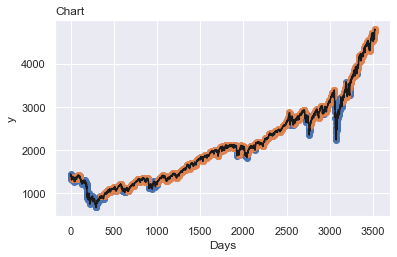

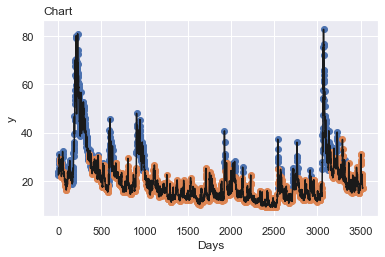

In [56]:
plotHMM(gspc[1:][["close"]], gspc_markov_results[0])
plotHMM(vix[1:][["close"]], gspc_markov_results[0])

##### Get MSDR Classifications

In [66]:
msdr_model = sm.tsa.MarkovRegression(endog=gspc_pct['close'], k_regimes=nRegimes,
    trend='c', exog=vix_pct["close"], switching_variance=True)

msdr_model_results = msdr_model.fit(iter=nIter)

# print model training summary
# print(msdr_model_results.summary())

marg_probs_msdr = [msdr_model_results.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style)
fig.add_trace(
        go.Scatter(y = gspc_pct["close"], x = gspc_pct.index, name = "GSPC % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msdr[i], x = gspc_pct.index, name = "GSPC+VIX Regime "+str(i)), 
        row=i+2, col=1,
    )

fig.show()
hidden_states_msdr_both = (marg_probs_msdr[0] > .5)*1

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.



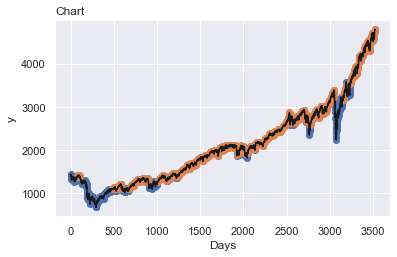

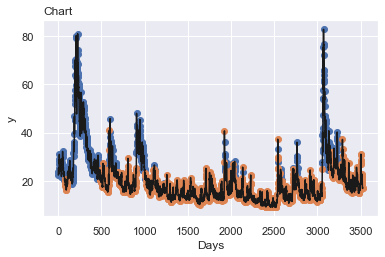

In [67]:
plotHMM(gspc[1:][["close"]], hidden_states_msdr_both)
plotHMM(vix[1:][["close"]], hidden_states_msdr_both)

In [73]:
hidden_states_msdr_both

formatted_date
2008-01-03    0
2008-01-04    0
2008-01-07    0
2008-01-08    0
2008-01-09    0
             ..
2021-12-23    1
2021-12-27    1
2021-12-28    1
2021-12-29    1
2021-12-30    1
Name: 0, Length: 3524, dtype: int32